# Détection de faux billets 💵

In [39]:
pip install pca

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=d022ecc384ae1b954b00a87332f35988b71d2827740c5d34804ddea8173c1a16
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=ff64f55b8ea727880e79fbd02805b4e6e4b6c04a77d4230becce632fa366c214
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built sklearn wget
Note: you may need to restart the kernel to use updated packages.


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize # Normalisation
from sklearn.preprocessing import StandardScaler
from pca import pca # ACP
import scipy.cluster.hierarchy as shc # Dendrogramme
from sklearn.cluster import AgglomerativeClustering # Récupération des clusters
import scipy.stats as stats # Tests statistiques
from scipy.special import boxcox1p
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier

In [11]:
# Couleurs
black = '#000'
red = '#d50000'
teal = '#00bfa5'
indigo = '#304ffe'
amber = '#ffab00'
purple = '#aa00ff'
palette = [red, teal, indigo, amber, purple, black]

# Données

In [2]:
source = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p6/notes.csv'
df = pd.read_csv(source)
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [3]:
df.info()

# --> Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [5]:
# Nombre de duplicats
print(len(df) - len(df.drop_duplicates()), 'duplicat')

0 duplicat


In [4]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [6]:
# Variables supplémentaires pour l'analyse
df['ratio_heights'] = df['height_left'] / df['height_right']
df['ratio_margins'] = df['margin_up'] / df['margin_low']
df.sample(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,ratio_heights,ratio_margins
49,True,171.59,103.23,103.64,4.01,2.94,113.59,0.996044,0.733167
56,True,172.53,103.99,103.55,4.50,3.10,113.03,1.004249,0.688889
102,False,171.94,104.21,104.10,4.28,3.47,112.23,1.001057,0.810748


# Corrélations

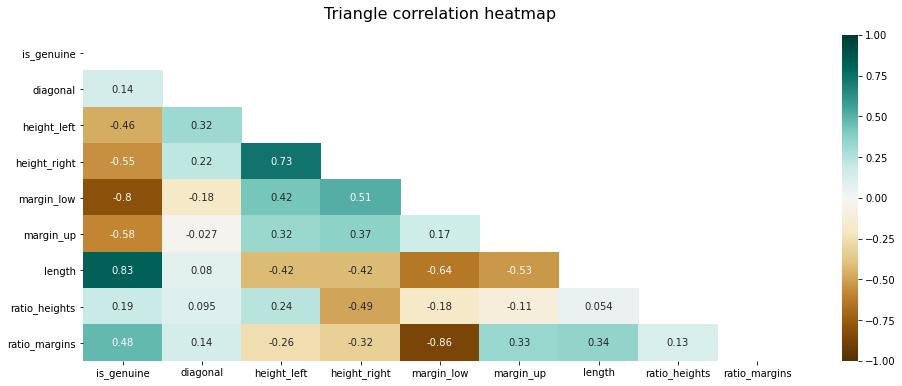

In [8]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

# --> La véracité du billet est corrélée positivement à la longueur, et négativement à la marge inférieure

# Box plots par variable

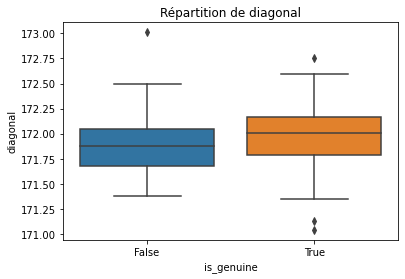

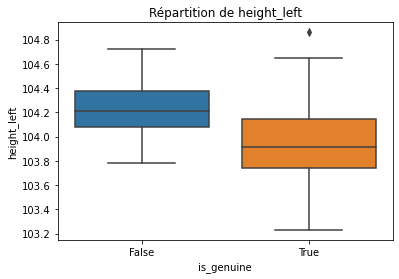

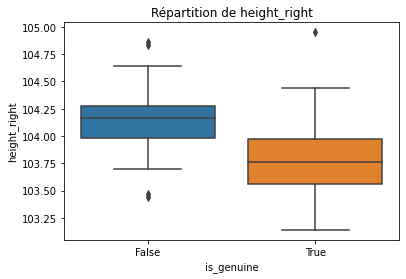

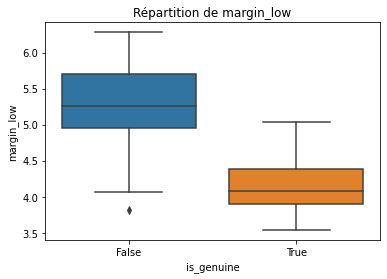

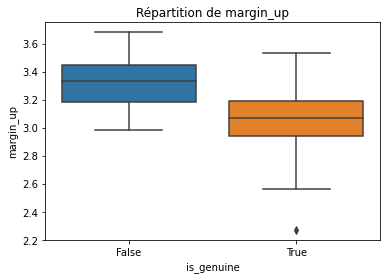

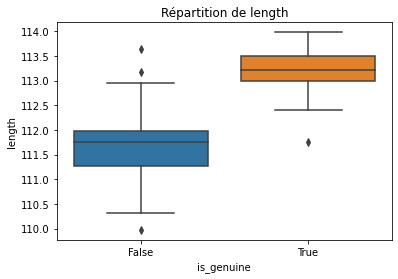

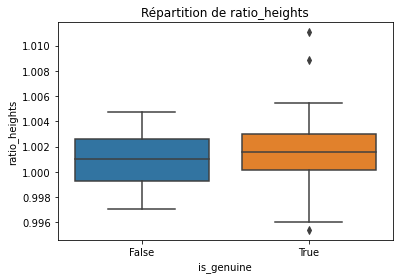

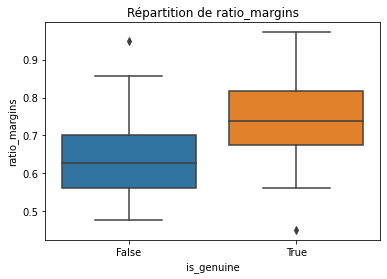

In [7]:
# Répartition des vrais et faux billets pour chaque variable
for i in df.columns[1:]:
    sns.boxplot(data=df, x='is_genuine', y=i)
    title = 'Répartition de ' + i
    plt.title(title)
    plt.show()
    
# --> Les diagonales des vrais et des faux billets sont similaires (légèrement supérieures chez les vrais)
# --> Les vrais billets ont des hauteurs et des marges plus petites que les faux
# --> Les vrais villets sont plus longs que les faux
# --> Le ratio entre les hauteurs est similaire chez les vrais et faux billets
# --> Le ratio entre les marges est plus inégal chez les vrais billets

# Visualisation des 2 clusters

Les couples de variables expliquant le mieux la variable **'is_genuine'** :
- longueur par marge basse
- marge basse par marge haute

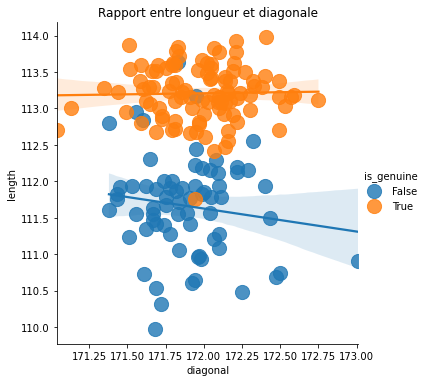

In [36]:
sns.lmplot(data=df, x='diagonal', y='length', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre longueur et diagonale')
plt.show()

# --> Populations distinctes, mais quelques chevauchements

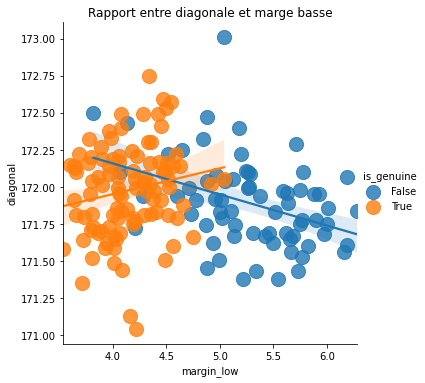

In [35]:
sns.lmplot(data=df, x='margin_low', y='diagonal', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre diagonale et marge basse')
plt.show()

# --> Populations distinctes, mais quelques chevauchements

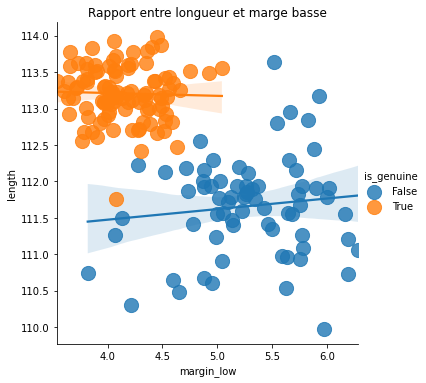

In [34]:
sns.lmplot(data=df, x='margin_low', y='length', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre longueur et marge basse')
plt.show()

# --> Populations quasi distinctes

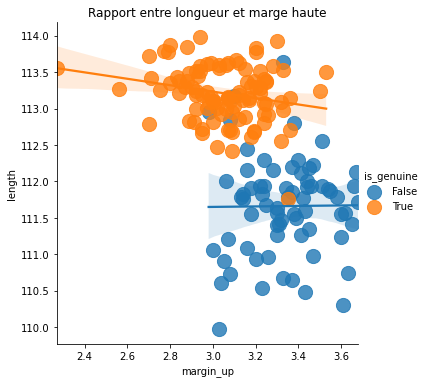

In [33]:
sns.lmplot(data=df, x='margin_up', y='length', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre longueur et marge haute')
plt.show()

# --> Populations distinctes, mais quelques chevauchements

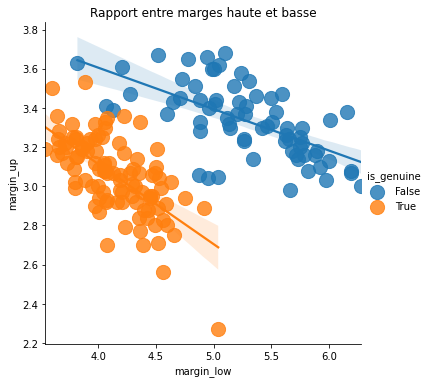

In [30]:
sns.lmplot(data=df, x='margin_low', y='margin_up', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre marges haute et basse')
plt.show()

# --> Populations quasi distinctes

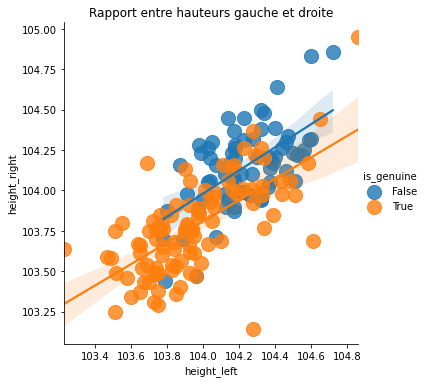

In [32]:
sns.lmplot(data=df, x='height_left', y='height_right', hue='is_genuine', scatter_kws={"s": 200})
plt.title('Rapport entre hauteurs gauche et droite')
plt.show()

# --> Le couple de variables n'explique pas 'is_genuine'

# ACP

## Normalisation des variables

In [43]:
df.sample()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,ratio_heights,ratio_margins
150,False,171.95,104.26,103.97,5.88,3.16,112.44,1.002789,0.537415


In [44]:
# Variables à normaliser et standardiser
variables_non_std = df.drop(['ratio_heights', 'ratio_margins'], axis=1)

# Centrage et réduction 
X = variables_non_std.values
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Réunion de toutes les variables standardisées
df_acp_standardscaler = pd.merge(
  df.drop(variables_non_std.columns, axis=1), # Variables n'ayant pas nécessité une standardisation
  pd.DataFrame(X_scaled, columns=variables_non_std.columns), # Variables précédemment standardisées
  left_index=True, right_index=True)
df_acp_standardscaler

,ratio_heights,ratio_margins,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.999142,0.639381,0.836660,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,1.000386,0.715711,0.836660,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,1.000000,0.654545,0.836660,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,1.001254,0.836461,0.836660,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.999518,0.450397,0.836660,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777
...,...,...,...,...,...,...,...,...,...
165,0.997894,0.683206,-1.195229,0.555689,0.550431,1.581436,0.896930,1.738009,-0.857535
166,1.002684,0.605159,-1.195229,3.507789,1.761301,1.157201,0.611230,-0.510944,-1.801418
167,1.001633,0.682377,-1.195229,1.736529,0.684972,0.520847,0.382670,0.677182,-2.050950
168,1.000866,0.750529,-1.195229,-0.395543,-0.324086,-0.145809,0.168395,1.610710,-0.759892


## Avec 2 composantes

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


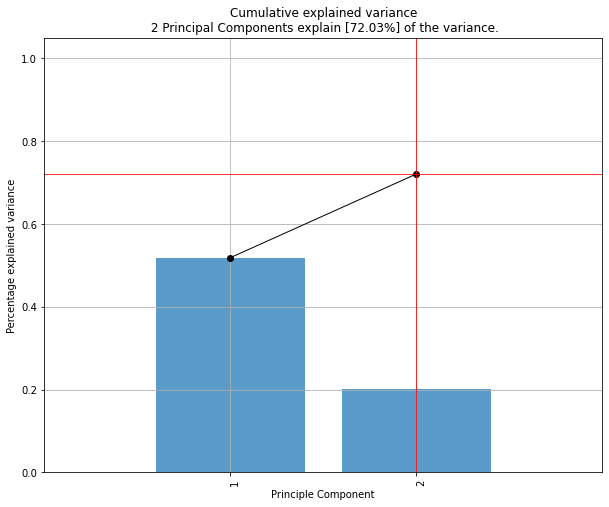

<Figure size 432x288 with 0 Axes>

In [50]:
model = pca(n_components=2)
results = model.fit_transform(df_acp_standardscaler)
fig, ax = model.plot()
plt.show()

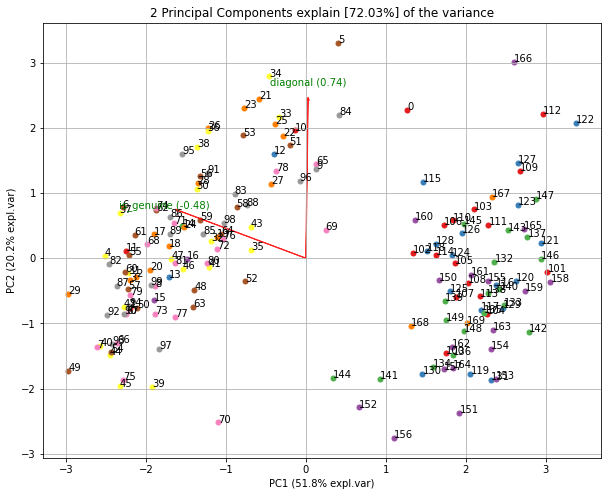

In [52]:
fig, ax = model.biplot(n_feat=2, legend=None)
plt.show()

## Clusters

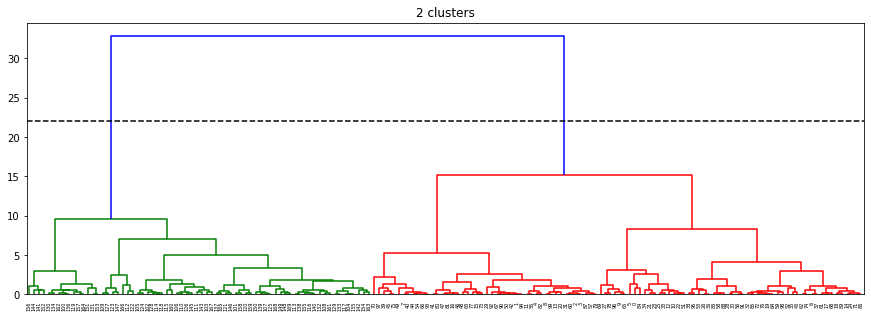

In [55]:
# Dendrogramme sur les 2 composantes de l'ACP
plt.figure(figsize=(15, 5))  
shc.dendrogram(shc.linkage(results['PC'], method='ward'))
plt.axhline(y=22, color='black', linestyle='dashed') # Threshold
plt.title('2 clusters')  
plt.show()

In [62]:
# Cluster pour chaque individu
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(results['PC']), columns=['Cluster'])
deux_composantes = pd.merge(results['PC'], clusters, left_index=True, right_index=True)
df = df.merge(deux_composantes, left_index=True, right_index=True)
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,ratio_heights,ratio_margins,PC1,PC2,Cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0.999142,0.639381,1.269604,2.273999,0
1,True,171.67,103.74,103.70,4.01,2.87,113.29,1.000386,0.715711,-2.206493,-0.761307,0
2,True,171.83,103.76,103.76,4.40,2.88,113.84,1.000000,0.654545,-2.121410,-0.285986,0
3,True,171.80,103.78,103.65,3.73,3.12,113.63,1.001254,0.836461,-2.200786,-0.338416,0
4,True,172.05,103.70,103.75,5.04,2.27,113.55,0.999518,0.450397,-2.518274,0.033668,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,0.997894,0.683206,2.727158,0.448994,1
166,False,173.01,104.59,104.31,5.04,3.05,110.91,1.002684,0.605159,2.607035,3.015575,1
167,False,172.47,104.27,104.10,4.88,3.33,110.68,1.001633,0.682377,2.332152,0.944751,1
168,False,171.82,103.97,103.88,4.73,3.55,111.87,1.000866,0.750529,1.315636,-1.041677,1


## Vérification des clusters

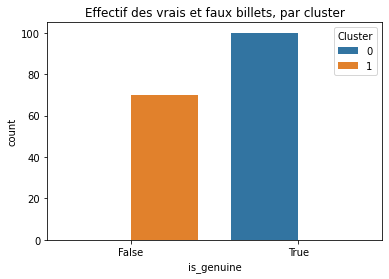

In [63]:
# Effectif pour vrai ou faux
sns.countplot(data=df, x='is_genuine', hue='Cluster')
plt.title('Effectif des vrais et faux billets, par cluster')
plt.show()

# --> Les clusters correspondent exactement aux billet vraix ou faux

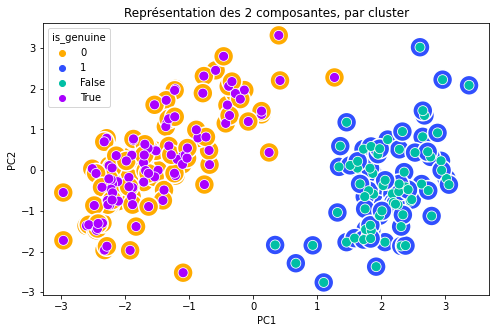

In [86]:
# Scatterplot des 2 composantes, par cluster
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x='PC1', y='PC2', hue='Cluster', 
    palette=[amber, indigo], s=400)
plt.title('Représentation des 2 composantes, par cluster')
sns.scatterplot(
    data=df, x='PC1', y='PC2', hue='is_genuine', 
    palette=[teal, purple], s=100)
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

# --> Les 2 clusters correspondent exactement aux billet vraix ou faux

# Modélisation

In [98]:
features = ['length', 'margin_low']

X_test = pd.DataFrame(
    [[110.0, 3.0], [122.0, 6.0], [119.2, 4.9], [116.2, 3.9]], # Liste de billets
    columns=features)
X_test

,length,margin_low
0,110.0,3.0
1,122.0,6.0
2,119.2,4.9
3,116.2,3.9


In [94]:
X = df[features]
X

,length,margin_low
0,112.83,4.52
1,113.29,4.01
2,113.84,4.40
3,113.63,3.73
4,113.55,5.04
...,...,...
165,111.78,5.24
166,110.91,5.04
167,110.68,4.88
168,111.87,4.73


In [95]:
y = df['is_genuine']
y

0       True
1       True
2       True
3       True
4       True
       ...  
165    False
166    False
167    False
168    False
169    False
Name: is_genuine, Length: 170, dtype: bool

In [96]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)
predictions

array([False, False,  True,  True])

In [97]:
output = pd.concat([X_test, pd.DataFrame(predictions, columns=['prediction'])], axis=1)
output

,length,margin_low,prediction
0,110.0,3.0,False
1,122.0,6.0,False
2,119.2,4.9,True
3,190.2,3.9,True
